# Supporting notebook for model development mockup

In [65]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import initializers
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [66]:
# Load embedded data
df = pd.read_csv('../data/data_embedded.csv')

In [67]:
# Initialise and fit label encoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df[["label"]])

C:\Users\bfeher\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [68]:
# Initialise and fit one-hot encoder
ohe = OneHotEncoder()
ohe.fit(df[['label_encoded']])
y_all = ohe.transform(df[['label_encoded']])

In [69]:
# Select features
X_all = df.iloc[:,:-3]

# Select labels
y_all = ohe.transform(df[['label_encoded']]).toarray()

In [70]:
# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, random_state=42, stratify=y_all)
print('Model will be trained on {} samples and tested on {} samples.'.format(len(X_train), len(X_test)))

Model will be trained on 332 samples and tested on 84 samples.


In [71]:
# Set class weights dict for Keras
class_weights = class_weight.compute_class_weight('balanced', np.unique(df['label']), df['label'])
class_weights_dict = dict(enumerate(class_weights))

C:\Users\bfeher\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['congenital_abnormalities' 'drug_related_side_effects'
 'drug_usage_congenital_abnormalities' 'psycholinguistics'], y=0      congenital_abnormalities
1      congenital_abnormalities
2      congenital_abnormalities
3      congenital_abnormalities
4      congenital_abnormalities
                 ...           
411           psycholinguistics
412           psycholinguistics
413           psycholinguistics
414           psycholinguistics
415           psycholinguistics
Name: label, Length: 416, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [73]:
# Define baseline model
def baseline_model():
    # Create model
    model = Sequential()
    model.add(Dense(y_train.shape[1], 
                    input_dim=X_train.shape[1], 
                    kernel_initializer='he_normal'))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_all, y_all, cv=kfold, fit_params = {'class_weight': class_weights_dict})
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 85.58% (0.96%)


In [74]:
# Get output dimension
output_dim = len(y_train[0])

# Create baseline model
model = Sequential()
model.add(Dense(output_dim, 
                input_dim=X_train.shape[1], 
                kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 20, batch_size=2, verbose=2, class_weight=class_weights_dict)

Train on 332 samples, validate on 84 samples
Epoch 1/20
 - 1s - loss: 1.1706 - acc: 0.6657 - val_loss: 0.7548 - val_acc: 0.6786
Epoch 2/20
 - 0s - loss: 0.8030 - acc: 0.7801 - val_loss: 0.5977 - val_acc: 0.7976
Epoch 3/20
 - 0s - loss: 0.6728 - acc: 0.8072 - val_loss: 0.4786 - val_acc: 0.8214
Epoch 4/20
 - 0s - loss: 0.5846 - acc: 0.8464 - val_loss: 0.6375 - val_acc: 0.6667
Epoch 5/20
 - 0s - loss: 0.5291 - acc: 0.8283 - val_loss: 0.5001 - val_acc: 0.7738
Epoch 6/20
 - 0s - loss: 0.4929 - acc: 0.8765 - val_loss: 0.5327 - val_acc: 0.7619
Epoch 7/20
 - 0s - loss: 0.4494 - acc: 0.9006 - val_loss: 0.4994 - val_acc: 0.7738
Epoch 8/20
 - 0s - loss: 0.4032 - acc: 0.9127 - val_loss: 0.5874 - val_acc: 0.7381
Epoch 9/20
 - 0s - loss: 0.3690 - acc: 0.9157 - val_loss: 0.4324 - val_acc: 0.7976
Epoch 10/20
 - 0s - loss: 0.3447 - acc: 0.9307 - val_loss: 0.5107 - val_acc: 0.7381
Epoch 11/20
 - 0s - loss: 0.3366 - acc: 0.9277 - val_loss: 0.4380 - val_acc: 0.7976
Epoch 12/20
 - 0s - loss: 0.3137 - acc: 

In [75]:
# Create predictions on test set and save to DataFrame
result_df = pd.DataFrame()
result_df['predictions'] = np.argmax(model.predict(X_test), axis=1)

In [76]:
# Merge test results to test dataframe
result_df = result_df.join(df.loc[X_test.index].reset_index(drop=True))

In [77]:
# Inverse transform labels
result_df['predicted_label'] = label_encoder.inverse_transform(result_df['predictions'])

In [12]:
print('Exporting results...')
result_df.to_csv('../data/test_results.csv', index=False)

Exporting results...


In [78]:
result_df.head(n=1)

predictions         0         1         2         3         4        5  \
0            1 -0.082671 -0.254825 -0.454661 -0.343112 -0.030383  0.27908   

          6         7        8  ...       762       763       764       765  \
0  0.393539  0.091315  0.03884  ...  0.355832 -0.080925 -0.100608 -0.190773   

        766       767                                           abstract  \
0  0.390664 -0.066003  There has been an increasing focus on drug ind...   

                                 label  label_encoded  \
0  drug_usage_congenital_abnormalities              2   

             predicted_label  
0  drug_related_side_effects  

[1 rows x 773 columns]

# Analyzing results

In [80]:
df = pd.read_csv('../data/test_results.csv')

In [81]:
df.head(n=1)

predictions                                           abstract  \
0   [0, 0, 1]  Using word learning as an example of a complex...   

               label    predicted_label  
0  psycholinguistics  psycholinguistics

Calculating confusion matrix...
Plotting confusion matrix...
Saving figure...


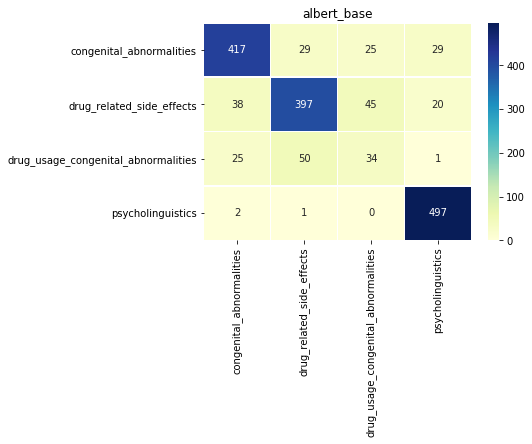

In [82]:
MODEL = 'albert_base'

labels = sorted(df['label'].unique())

print('Calculating confusion matrix...')
cm = confusion_matrix(df['label'], df['predicted_label'], labels=labels)

print('Plotting confusion matrix...')
sns_plot = sns.heatmap(cm, annot=True, fmt='.0f', linewidths=.5, cmap="YlGnBu", 
            xticklabels=labels, 
            yticklabels=labels).set_title(MODEL)

print('Saving figure...')
sns_plot.figure.savefig("../results/confusion_matrix_" + str(MODEL) + ".png", bbox_inches='tight')

In [83]:
print(classification_report(df['label'], df['predicted_label'], target_names=labels))

                                     precision    recall  f1-score   support

           congenital_abnormalities       0.87      0.83      0.85       500
          drug_related_side_effects       0.83      0.79      0.81       500
drug_usage_congenital_abnormalities       0.33      0.31      0.32       110
                  psycholinguistics       0.91      0.99      0.95       500

                           accuracy                           0.84      1610
                          macro avg       0.73      0.73      0.73      1610
                       weighted avg       0.83      0.84      0.83      1610



In [ ]:
print('Creating and exporting classification report...')
pd.DataFrame(classification_report(df['label'], df['predicted_label'], target_names=labels, output_dict=True)).to_csv('../results/classification_report.csv', index=False)

In [85]:
pd.DataFrame(classification_report(df['label'], df['predicted_label'], target_names=labels, output_dict=True))

congenital_abnormalities  drug_related_side_effects  \
precision                  0.865145                   0.832285   
recall                     0.834000                   0.794000   
f1-score                   0.849287                   0.812692   
support                  500.000000                 500.000000   

           drug_usage_congenital_abnormalities  psycholinguistics  accuracy  \
precision                             0.326923           0.908592  0.835404   
recall                                0.309091           0.994000  0.835404   
f1-score                              0.317757           0.949379  0.835404   
support                             110.000000         500.000000  0.835404   

             macro avg  weighted avg  
precision     0.733236      0.831660  
recall        0.732773      0.835404  
f1-score      0.732279      0.832691  
support    1610.000000   1610.000000

# Multilabel setup

In [86]:
df = pd.read_csv('../data/data_embedded.csv')

In [87]:
# Create multilabel targets
def create_multilabel_targets(label):
    if label == 'congenital_abnormalities':
        return np.array([1, 0, 0])
    elif label == 'drug_related_side_effects':
        return np.array([0, 1, 0])
    elif label == 'drug_usage_congenital_abnormalities':
        return np.array([1, 1, 0])
    else:
        return np.array([0, 0, 1])
    
df['multilabel_target'] = df['label'].apply(lambda x: create_multilabel_targets(x))

In [88]:
# Select features
X_all = df.iloc[:,:-3]

# Select labels
y_all = np.array(df['multilabel_target'].tolist())

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, random_state=42, stratify=y_all)
print('Model will be trained on {} samples and tested on {} samples.'.format(len(X_train), len(X_test)))

Model will be trained on 332 samples and tested on 84 samples.


In [90]:
# Get output dim
output_dim = len(y_train[0])

# Create baseline model
model = Sequential()
model.add(Dense(output_dim, 
                input_dim=X_train.shape[1], 
                kernel_initializer='he_normal'))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 20, batch_size=2, verbose=2,
         class_weight=class_weights_dict)

Train on 332 samples, validate on 84 samples
Epoch 1/20
 - 1s - loss: 0.7975 - acc: 0.6857 - val_loss: 0.4202 - val_acc: 0.7976
Epoch 2/20
 - 0s - loss: 0.4348 - acc: 0.8373 - val_loss: 0.3469 - val_acc: 0.8214
Epoch 3/20
 - 0s - loss: 0.3355 - acc: 0.8675 - val_loss: 0.2864 - val_acc: 0.8571
Epoch 4/20
 - 0s - loss: 0.2825 - acc: 0.9016 - val_loss: 0.2697 - val_acc: 0.8651
Epoch 5/20
 - 0s - loss: 0.2499 - acc: 0.9116 - val_loss: 0.2831 - val_acc: 0.8730
Epoch 6/20
 - 0s - loss: 0.2274 - acc: 0.9187 - val_loss: 0.2547 - val_acc: 0.8690
Epoch 7/20
 - 0s - loss: 0.2056 - acc: 0.9267 - val_loss: 0.2695 - val_acc: 0.8770
Epoch 8/20
 - 0s - loss: 0.1955 - acc: 0.9307 - val_loss: 0.2366 - val_acc: 0.9008
Epoch 9/20
 - 0s - loss: 0.1808 - acc: 0.9357 - val_loss: 0.2304 - val_acc: 0.8968
Epoch 10/20
 - 0s - loss: 0.1715 - acc: 0.9367 - val_loss: 0.2278 - val_acc: 0.9048
Epoch 11/20
 - 0s - loss: 0.1609 - acc: 0.9468 - val_loss: 0.2330 - val_acc: 0.9048
Epoch 12/20
 - 0s - loss: 0.1558 - acc: 

In [91]:
# Define baseline model
def baseline_model_multilabel():
    # Create model
    model = Sequential()
    model.add(Dense(y_train.shape[1], 
                    input_dim=X_train.shape[1], 
                    kernel_initializer='he_normal'))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model_multilabel, epochs=20, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_all, y_all, cv=kfold,  fit_params = {'class_weight': class_weights_dict})
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 90.79% (0.72%)


In [92]:
# Create predictions on test set and save to DataFrame
result_df = pd.DataFrame()
result_df['predictions'] = (model.predict(X_test) > 0.5).astype("int32").tolist()

In [93]:
# Merge test results to test dataframe
result_df = result_df.join(df.loc[X_test.index].reset_index(drop=True))

In [94]:
# Inverse transform labels

def inverse_transfor_multilabel_targets(label):
    if label == [1, 0, 0]:
        return 'congenital_abnormalities'
    elif label == [0, 1, 0]:
        return 'drug_related_side_effects'
    elif label == [1, 1, 0]:
        return 'drug_usage_congenital_abnormalities'
    else:
        return 'psycholinguistics'
    
result_df['predicted_label'] = result_df['predictions'].apply(lambda x: inverse_transfor_multilabel_targets(x))

In [95]:
print('Exporting results...')
result_df.to_csv('../data/test_results.csv', index=False)

Exporting results...


# Analyzing multilabel results

In [98]:
df = pd.read_csv('../data/test_results.csv')

In [99]:
df.head(n=1)

predictions         0         1         2         3        4         5  \
0   [0, 0, 1]  0.090383 -0.326809 -0.215052 -0.316742  0.08073  0.234305   

          6         7         8  ...      762       763       764       765  \
0  0.190177 -0.045501 -0.086676  ...  0.33571 -0.048164 -0.286822 -0.078171   

        766       767                                           abstract  \
0  0.260093 -0.221414  During conversation, interlocutors often produ...   

               label  multilabel_target    predicted_label  
0  psycholinguistics            [0 0 1]  psycholinguistics  

[1 rows x 773 columns]

Calculating confusion matrix...
Plotting confusion matrix...
Saving figure...


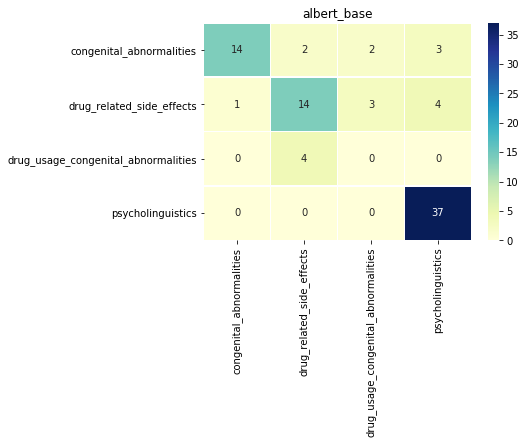

In [100]:
MODEL = 'albert_base'

labels = sorted(df['label'].unique())

print('Calculating confusion matrix...')
cm = confusion_matrix(df['label'], df['predicted_label'], labels=labels)

print('Plotting confusion matrix...')
sns_plot = sns.heatmap(cm, annot=True, fmt='.0f', linewidths=.5, cmap="YlGnBu", 
            xticklabels=labels, 
            yticklabels=labels).set_title(MODEL)

print('Saving figure...')
sns_plot.figure.savefig("../results/confusion_matrix_" + str(MODEL) + ".png", bbox_inches='tight')

In [101]:
labels = sorted(df['label'].unique())
print(classification_report(df['label'], df['predicted_label'], target_names=labels))

                                     precision    recall  f1-score   support

           congenital_abnormalities       0.93      0.67      0.78        21
          drug_related_side_effects       0.70      0.64      0.67        22
drug_usage_congenital_abnormalities       0.00      0.00      0.00         4
                  psycholinguistics       0.84      1.00      0.91        37

                           accuracy                           0.77        84
                          macro avg       0.62      0.58      0.59        84
                       weighted avg       0.79      0.77      0.77        84



In [ ]:
print('Creating and exporting classification report...')
pd.DataFrame(classification_report(df['label'], df['predicted_label'], target_names=labels, output_dict=True)).to_csv('../results/classification_report.csv', index=False)